# GNN-Based Healthcare Fraud Detection on Synthetic Data

Applying Graph Neural Network methods from testing_AC.ipynb to synthetic healthcare provider data.

**Dataset**: Synthetic healthcare providers with potential fraud indicators
- 1M records (Individual & Organization providers)
- Features: NPI, SSN/EIN, licenses, bank info, risk scores, claim amounts
- Built-in duplicates (2% exact, 2% fuzzy) for fraud detection

## 1. Setup & Data Loading

In [46]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [47]:
# Load synthetic healthcare data
df = pd.read_csv('../dbx/synthetic_data/output/synthetic_data_v1.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1000000, 30)

Columns: ['NPI', 'Provider_Type', 'Provider_Name', 'SSN', 'ssn_ein', 'Contact_Email', 'DOB', 'Gender', 'Contact_Phone', 'Practice_Address', 'Mailing_Address', 'State_License_Number', 'License_State', 'License_Expiration', 'DEA_Number', 'Specialty_Code', 'Board_Certification', 'Accreditation_Org', 'Accreditation_Exp', 'Ownership_Type', 'Adverse_Actions', 'Bank_Account_Number', 'Bank_Routing_Number', 'BANK', 'Billing_Agency', 'Reassignment_Of_Benefits', 'Enrollment_Date', 'Last_Updated', 'Risk_Score', 'Claim_Amount']

First few rows:


,NPI,Provider_Type,Provider_Name,SSN,ssn_ein,Contact_Email,DOB,Gender,Contact_Phone,Practice_Address,...,Adverse_Actions,Bank_Account_Number,Bank_Routing_Number,BANK,Billing_Agency,Reassignment_Of_Benefits,Enrollment_Date,Last_Updated,Risk_Score,Claim_Amount
0,2204839288,Individual,David Freeman,793-64-3131,NaN,amcdonald@example.com,01/18/1943,Male,+698-811-3495,"88052 Tammy Trace, South Jasonside, OH 88674",...,NaN,7408834063,379315335,7408834063-379315335,"Larson, Williams and Fletcher",N,06/08/2019,10/07/2025,10,9127004
1,2916123637,Individual,Beverly Sullivan,451-83-4444,NaN,jessica50@example.org,12/29/1956,Female,+315-572-5957,"49955 Cunningham Spurs, East Andreafurt, ID 30712",...,NaN,773512247607,525051015,773512247607-525051015,NaN,Y,07/28/2006,10/07/2025,9,4112889
2,2851443834,Individual,Elizabeth Page,152-80-5726,NaN,smithtyler@example.org,02/11/1995,Female,+401-270-1779,"229 Archer Lights Apt. 228, East Juliestad, CA...",...,NaN,23577011,107420168,23577011-107420168,NaN,Y,07/28/2007,10/07/2025,0,3749549
3,2948318909,Organization,"Webb, Jones and Patterson",NaN,66-8298889,zmartin@example.org,NaN,NaN,+944-494-3505,"14280 Wade Mission Suite 934, Lake Tina, GU 31375",...,NaN,190087723233,856877165,190087723233-856877165,Novak PLC,Y,03/14/2015,10/07/2025,0,6922172
4,2278088820,Organization,Mahoney-Davis,NaN,53-1127783,tmorton@example.net,NaN,NaN,+211-541-7623,"119 Andrew Lodge Apt. 436, South Christopher, ...",...,NaN,924966169523,867514551,924966169523-867514551,Stewart-Carpenter,Y,08/18/2012,10/07/2025,0,8554067


In [48]:
# Data overview
print("Data Info:")
print(df.info())
print(f"\nProvider Type Distribution:")
print(df['Provider_Type'].value_counts())
print(f"\nRisk Score Distribution:")
print(df['Risk_Score'].value_counts().sort_index())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 30 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   NPI                       1000000 non-null  int64 
 1   Provider_Type             1000000 non-null  object
 2   Provider_Name             1000000 non-null  object
 3   SSN                       700523 non-null   object
 4   ssn_ein                   299477 non-null   object
 5   Contact_Email             1000000 non-null  object
 6   DOB                       700523 non-null   object
 7   Gender                    700523 non-null   object
 8   Contact_Phone             1000000 non-null  object
 9   Practice_Address          1000000 non-null  object
 10  Mailing_Address           1000000 non-null  object
 11  State_License_Number      1000000 non-null  object
 12  License_State             1000000 non-null  object
 13  License_Expiration        100000

## 2. Fraud Label Generation

Create fraud labels based on:
- Risk scores (high risk = fraud)
- Duplicate detection (exact/fuzzy matches)
- Adverse actions
- Anomalous claim amounts

In [49]:
# Create fraud labels based on multiple criteria
def create_fraud_labels(df):
    fraud_indicators = []
    
    # 1. High risk scores (>10) indicate fraud
    fraud_indicators.append(df['Risk_Score'] > 10)
    
    # 2. Adverse actions (Malpractice/Suspension)
    fraud_indicators.append(df['Adverse_Actions'].isin(['Malpractice', 'Suspension']))
    
    # 3. Duplicate SSN/EIN (exact duplicates)
    ssn_dups = df[df['SSN'].notna()].duplicated(subset=['SSN'], keep=False)
    ein_dups = df[df['ssn_ein'].notna()].duplicated(subset=['ssn_ein'], keep=False)
    fraud_indicators.append(ssn_dups | ein_dups)
    
    # 4. Duplicate BANK accounts (potential money laundering)
    bank_dups = df.duplicated(subset=['BANK'], keep=False)
    fraud_indicators.append(bank_dups)
    
    # 5. Extremely high claims (top 5%)
    high_claims = df['Claim_Amount'] > df['Claim_Amount'].quantile(0.95)
    fraud_indicators.append(high_claims)
    
    # Combine: Any indicator triggers fraud label
    is_fraud = np.logical_or.reduce(fraud_indicators)
    
    return is_fraud.astype(int)

df['is_fraud'] = create_fraud_labels(df)

print(f"Fraud Distribution:")
print(df['is_fraud'].value_counts())
print(f"\nFraud Ratio: {df['is_fraud'].mean():.3%}")

Fraud Distribution:
is_fraud
0    738666
1    261334
Name: count, dtype: int64

Fraud Ratio: 26.133%


## 3. Graph Construction

Build a heterogeneous provider network based on:
- Shared bank accounts (financial connections)
- Same billing agency
- Same license state (geographic proximity)
- Similar specialty codes

In [50]:
def build_provider_graph(df, sample_size=50000):
    """
    Build graph where nodes are providers and edges represent relationships
    
    Sample a subset for computational efficiency
    """
    # Sample data for manageable graph size
    if len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    else:
        df_sample = df.copy()
    
    print(f"Building graph with {len(df_sample)} nodes...")
    
    edges = []
    
    # 1. Connect providers with same BANK account (strong fraud indicator)
    bank_groups = df_sample.groupby('BANK').groups
    for bank, indices in bank_groups.items():
        if len(indices) > 1:  # At least 2 providers share this bank
            indices = list(indices)
            for i in range(len(indices)):
                for j in range(i+1, len(indices)):
                    edges.append([indices[i], indices[j]])
                    edges.append([indices[j], indices[i]])  # Undirected
    
    # 2. Connect providers with same Billing Agency
    billing_groups = df_sample[df_sample['Billing_Agency'].notna()].groupby('Billing_Agency').groups
    for agency, indices in billing_groups.items():
        if len(indices) > 1 and len(indices) < 100:  # Avoid super-nodes
            indices = list(indices)
            for i in range(len(indices)):
                for j in range(i+1, min(i+5, len(indices))):  # Limit connections
                    edges.append([indices[i], indices[j]])
                    edges.append([indices[j], indices[i]])
    
    # 3. Connect providers in same state with same specialty
    state_specialty = df_sample.groupby(['License_State', 'Specialty_Code']).groups
    for (state, spec), indices in state_specialty.items():
        if len(indices) > 1 and len(indices) < 50:
            indices = list(indices)
            for i in range(len(indices)):
                for j in range(i+1, min(i+3, len(indices))):  # Sparse connections
                    edges.append([indices[i], indices[j]])
                    edges.append([indices[j], indices[i]])
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)
    
    print(f"Created {edge_index.shape[1]} edges")
    
    return df_sample, edge_index

# Build graph (sample 50k nodes for performance)
df_graph, edge_index = build_provider_graph(df, sample_size=50000)

Building graph with 50000 nodes...
Created 24004 edges


## 4. Feature Engineering

In [ ]:
# def create_node_features(df):
#     """
#     Create numerical feature matrix for GNN
#     """
#     G = nx.Graph()
#     G.add_nodes_from(range(len(df)))
    
#     # Add edges
#     if edge_index.shape[1] > 0:
#         edges = edge_index.t().cpu().numpy()
#         G.add_edges_from(edges)
    
#     features = []
    
#     # 1. Provider Type (Individual=1, Organization=0)
#     features.append(df['Provider_Type'].map({'Individual': 1, 'Organization': 0}).values.reshape(-1, 1))
    
#     # 2. Risk Score (normalized)
#     risk_norm = df['Risk_Score'].values.reshape(-1, 1) / 20.0
#     features.append(risk_norm)
    
#     # 3. Claim Amount (log-scaled and normalized)
#     claim_log = np.log1p(df['Claim_Amount'].values).reshape(-1, 1)
#     claim_norm = (claim_log - claim_log.mean()) / claim_log.std()
#     features.append(claim_norm)
    
#     # 4. Board Certification
#     board_cert = df['Board_Certification'].map({'Yes': 1, 'No': 0, np.nan: 0}).values.reshape(-1, 1)
#     features.append(board_cert)
    
#     # 5. Adverse Actions (encoded)
#     adverse = df['Adverse_Actions'].map({'None': 0, 'Malpractice': 1, 'Suspension': 2}).fillna(0).values.reshape(-1, 1)
#     features.append(adverse / 2.0)  # Normalize
    
#     # 6. Specialty Code (label encoded)
#     le_spec = LabelEncoder()
#     specialty = le_spec.fit_transform(df['Specialty_Code'].astype(str)).reshape(-1, 1)
#     features.append(specialty / specialty.max())  # Normalize
    
#     # 7. License State (label encoded)
#     le_state = LabelEncoder()
#     state = le_state.fit_transform(df['License_State']).reshape(-1, 1)
#     features.append(state / state.max())
    
#     # 8. Has Billing Agency (binary)
#     has_billing = df['Billing_Agency'].notna().astype(int).values.reshape(-1, 1)
#     features.append(has_billing)
    
#     # 9. Reassignment of Benefits
#     reassignment = df['Reassignment_Of_Benefits'].map({'Y': 1, 'N': 0}).values.reshape(-1, 1)
#     features.append(reassignment)
    
#     # 10. Enrollment age (days since enrollment, normalized)
#     enrollment_dates = pd.to_datetime(df['Enrollment_Date'])
#     days_enrolled = (pd.Timestamp('2025-10-07') - enrollment_dates).dt.days.values.reshape(-1, 1)
#     days_norm = days_enrolled / days_enrolled.max()
#     features.append(days_norm)

#     # 11. Degree Centrality
#     degree_dict = dict(G.degree())
#     degrees = np.array([degree_dict.get(i, 0) for i in range(len(df))]).reshape(-1, 1)
#     degree_norm = degrees / (degrees.max() + 1e-10)
#     features.append(degree_norm)
    
#     # 12. PageRank
#     pagerank_dict = nx.pagerank(G, max_iter=50, tol=1e-4)
#     pagerank = np.array([pagerank_dict.get(i, 0) for i in range(len(df))]).reshape(-1, 1)
#     features.append(pagerank)
    
#     # 13. Betweenness Centrality (with sampling for efficiency)
#     if G.number_of_nodes() > 10000:
#         k = min(1000, G.number_of_nodes())
#         betweenness_dict = nx.betweenness_centrality(G, k=k)
#     else:
#         betweenness_dict = nx.betweenness_centrality(G)
    
#     # 14. Closeness Centrality
#     closeness_dict = nx.closeness_centrality(G)
    
#     # 15. Eigenvector Centrality
#     eigenvector_dict = nx.eigenvector_centrality(G, max_iter=100, tol=1e-4)
    
#     # 16. Katz Centrality
#     katz_dict = nx.katz_centrality(G, max_iter=100, tol=1e-4, alpha=0.01)
    
#     # 17. Clustering Coefficient
#     clustering_dict = nx.clustering(G)
    
#     # 18. K-Core Number
#     core_dict = nx.core_number(G)
    
#     # 19. Triangles
#     triangles_dict = nx.triangles(G)
    
#     # 20-23. Laplacian Positional Encodings (4D)
#     from scipy.sparse.linalg import eigsh
#     L = nx.normalized_laplacian_matrix(G)
#     k = min(4, G.number_of_nodes() - 2)
#     eigenvalues, eigenvectors = eigsh(L, k=k, which='SM', tol=1e-4)
    
#     # Concatenate all features
#     X = np.hstack(features)
    
#     return torch.tensor(X, dtype=torch.float)

# # Create features
# node_features = create_node_features(df_graph)
# print(f"Node feature matrix shape: {node_features.shape}")
# print(f"Number of features per node: {node_features.shape[1]}")

Node feature matrix shape: torch.Size([50000, 12])
Number of features per node: 12


In [84]:
def create_node_features(df, edge_index):
    """
    Create comprehensive numerical feature matrix for GNN
    Includes node attributes + graph structural features
    """
    import networkx as nx
    from sklearn.decomposition import PCA
    
    print("Creating node features with graph analytics...")
    
    # Convert to NetworkX for centrality calculations
    G = nx.Graph()
    G.add_nodes_from(range(len(df)))
    
    # Add edges
    if edge_index.shape[1] > 0:
        edges = edge_index.t().cpu().numpy()
        G.add_edges_from(edges)
    
    print(f"  Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    features = []
    
    # ========================================================================
    # PART 1: NODE ATTRIBUTES (Original Features)
    # ========================================================================
    
    # 1. Provider Type (Individual=1, Organization=0)
    features.append(df['Provider_Type'].map({'Individual': 1, 'Organization': 0}).values.reshape(-1, 1))
    
    # 2. Risk Score (normalized)
    risk_norm = df['Risk_Score'].values.reshape(-1, 1) / 20.0
    features.append(risk_norm)
    
    # 3. Claim Amount (log-scaled and normalized)
    claim_log = np.log1p(df['Claim_Amount'].values).reshape(-1, 1)
    claim_norm = (claim_log - claim_log.mean()) / claim_log.std()
    features.append(claim_norm)
    
    # 4. Board Certification
    board_cert = df['Board_Certification'].map({'Yes': 1, 'No': 0, np.nan: 0}).values.reshape(-1, 1)
    features.append(board_cert)
    
    # 5. Adverse Actions (encoded)
    adverse = df['Adverse_Actions'].map({'None': 0, 'Malpractice': 1, 'Suspension': 2}).fillna(0).values.reshape(-1, 1)
    features.append(adverse / 2.0)  # Normalize
    
    # 6. Specialty Code (label encoded)
    le_spec = LabelEncoder()
    specialty = le_spec.fit_transform(df['Specialty_Code'].astype(str)).reshape(-1, 1)
    features.append(specialty / specialty.max())  # Normalize
    
    # 7. License State (label encoded)
    le_state = LabelEncoder()
    state = le_state.fit_transform(df['License_State']).reshape(-1, 1)
    features.append(state / state.max())
    
    # 8. Has Billing Agency (binary)
    has_billing = df['Billing_Agency'].notna().astype(int).values.reshape(-1, 1)
    features.append(has_billing)
    
    # 9. Reassignment of Benefits
    reassignment = df['Reassignment_Of_Benefits'].map({'Y': 1, 'N': 0}).values.reshape(-1, 1)
    features.append(reassignment)
    
    # 10. Enrollment age (days since enrollment, normalized)
    enrollment_dates = pd.to_datetime(df['Enrollment_Date'])
    days_enrolled = (pd.Timestamp('2025-10-07') - enrollment_dates).dt.days.values.reshape(-1, 1)
    days_norm = days_enrolled / days_enrolled.max()
    features.append(days_norm)
    
    # ========================================================================
    # PART 2: GRAPH STRUCTURAL FEATURES
    # ========================================================================
    
    print("  Computing centrality measures...")
    
    # 11. Degree Centrality
    degree_dict = dict(G.degree())
    degrees = np.array([degree_dict.get(i, 0) for i in range(len(df))]).reshape(-1, 1)
    degree_norm = degrees / (degrees.max() + 1e-10)
    features.append(degree_norm)
    
    # 12. PageRank (importance based on connections)
    try:
        pagerank_dict = nx.pagerank(G, max_iter=50, tol=1e-4)
        pagerank = np.array([pagerank_dict.get(i, 0) for i in range(len(df))]).reshape(-1, 1)
        pagerank_norm = (pagerank - pagerank.mean()) / (pagerank.std() + 1e-10)
        features.append(pagerank_norm)
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 13. Betweenness Centrality (bridging role)
    print("  Computing betweenness centrality...")
    try:
        # Sample for efficiency on large graphs
        if G.number_of_nodes() > 10000:
            k = min(1000, G.number_of_nodes())
            betweenness_dict = nx.betweenness_centrality(G, k=k)
        else:
            betweenness_dict = nx.betweenness_centrality(G)
        betweenness = np.array([betweenness_dict.get(i, 0) for i in range(len(df))]).reshape(-1, 1)
        betweenness_norm = (betweenness - betweenness.mean()) / (betweenness.std() + 1e-10)
        features.append(betweenness_norm)
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 14. Closeness Centrality (average distance to others)
    print("  Computing closeness centrality...")
    try:
        closeness_dict = nx.closeness_centrality(G)
        closeness = np.array([closeness_dict.get(i, 0) for i in range(len(df))]).reshape(-1, 1)
        closeness_norm = (closeness - closeness.mean()) / (closeness.std() + 1e-10)
        features.append(closeness_norm)
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 15. Eigenvector Centrality (influence based on connections)
    print("  Computing eigenvector centrality...")
    try:
        eigenvector_dict = nx.eigenvector_centrality(G, max_iter=100, tol=1e-4)
        eigenvector = np.array([eigenvector_dict.get(i, 0) for i in range(len(df))]).reshape(-1, 1)
        eigenvector_norm = (eigenvector - eigenvector.mean()) / (eigenvector.std() + 1e-10)
        features.append(eigenvector_norm)
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 16. Katz Centrality (weighted paths)
    print("  Computing Katz centrality...")
    try:
        katz_dict = nx.katz_centrality(G, max_iter=100, tol=1e-4, alpha=0.01)
        katz = np.array([katz_dict.get(i, 0) for i in range(len(df))]).reshape(-1, 1)
        katz_norm = (katz - katz.mean()) / (katz.std() + 1e-10)
        features.append(katz_norm)
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 17. Clustering Coefficient (local connectivity)
    print("  Computing clustering coefficients...")
    try:
        clustering_dict = nx.clustering(G)
        clustering = np.array([clustering_dict.get(i, 0) for i in range(len(df))]).reshape(-1, 1)
        features.append(clustering)
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 18. K-Core Number (cohesive subgroup membership)
    print("  Computing k-core decomposition...")
    try:
        core_dict = nx.core_number(G)
        core_numbers = np.array([core_dict.get(i, 0) for i in range(len(df))]).reshape(-1, 1)
        core_norm = core_numbers / (core_numbers.max() + 1e-10)
        features.append(core_norm)
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 19. Triangles (number of triangles node participates in)
    print("  Computing triangle count...")
    try:
        triangles_dict = nx.triangles(G)
        triangles = np.array([triangles_dict.get(i, 0) for i in range(len(df))]).reshape(-1, 1)
        triangles_norm = np.log1p(triangles) / (np.log1p(triangles).max() + 1e-10)
        features.append(triangles_norm)
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 20-23. Laplacian Positional Encodings (4D)
    print("  Computing Laplacian positional encodings...")
    try:
        from scipy.sparse import csr_matrix
        from scipy.sparse.linalg import eigsh
        
        # Compute normalized Laplacian
        L = nx.normalized_laplacian_matrix(G)
        
        # Get smallest non-zero eigenvalues/eigenvectors
        k = min(4, G.number_of_nodes() - 2)
        if k > 0:
            eigenvalues, eigenvectors = eigsh(L, k=k, which='SM', tol=1e-4)
            
            # Pad if needed
            if eigenvectors.shape[1] < 4:
                padding = np.zeros((eigenvectors.shape[0], 4 - eigenvectors.shape[1]))
                eigenvectors = np.hstack([eigenvectors, padding])
            
            # Normalize
            for i in range(4):
                eig_vec = eigenvectors[:, i].reshape(-1, 1)
                eig_norm = (eig_vec - eig_vec.mean()) / (eig_vec.std() + 1e-10)
                features.append(eig_norm)
        else:
            for _ in range(4):
                features.append(np.zeros((len(df), 1)))
    except:
        for _ in range(4):
            features.append(np.zeros((len(df), 1)))

     # ========================================================================
    # PART 3: TEMPORAL FEATURES
    # ========================================================================
    
    print("  Computing temporal features...")
    
    # Parse enrollment dates for temporal analysis
    enrollment_timestamps = enrollment_dates.values.astype('datetime64[s]').astype(np.int64)
    current_timestamp = pd.Timestamp('2025-10-07').value // 10**9
    
    # Normalize timestamps to [0, 1] range
    min_ts = enrollment_timestamps.min()
    max_ts = enrollment_timestamps.max()
    ts_norm = (enrollment_timestamps - min_ts) / (max_ts - min_ts + 1e-10)
    
    # 24-27. Time2Vec Periodic Encodings (4D)
    # Time2Vec learns periodic patterns with sin/cos transformations
    print("  Computing Time2Vec encodings...")
    try:
        # Linear component
        time_linear = ts_norm.reshape(-1, 1)
        features.append(time_linear)
        
        # Periodic components (3 frequencies)
        for freq in [1.0, 2.0, 4.0]:
            time_periodic = np.sin(2 * np.pi * freq * ts_norm).reshape(-1, 1)
            features.append(time_periodic)
    except:
        for _ in range(4):
            features.append(np.zeros((len(df), 1)))
    
    # 28-30. Transaction Frequency (multiple time windows)
    # Simulated using claim amounts as proxy for transaction activity
    print("  Computing transaction frequency features...")
    try:
        # Group by provider and compute rolling statistics
        # Window 1: 30 days
        window_30d = 30 * 24 * 3600
        recent_mask_30d = (current_timestamp - enrollment_timestamps) <= window_30d
        freq_30d = np.where(recent_mask_30d, df['Claim_Amount'].values / 30, 0).reshape(-1, 1)
        freq_30d_norm = freq_30d / (freq_30d.max() + 1e-10)
        features.append(freq_30d_norm)
        
        # Window 2: 90 days
        window_90d = 90 * 24 * 3600
        recent_mask_90d = (current_timestamp - enrollment_timestamps) <= window_90d
        freq_90d = np.where(recent_mask_90d, df['Claim_Amount'].values / 90, 0).reshape(-1, 1)
        freq_90d_norm = freq_90d / (freq_90d.max() + 1e-10)
        features.append(freq_90d_norm)
        
        # Window 3: 365 days
        window_365d = 365 * 24 * 3600
        recent_mask_365d = (current_timestamp - enrollment_timestamps) <= window_365d
        freq_365d = np.where(recent_mask_365d, df['Claim_Amount'].values / 365, 0).reshape(-1, 1)
        freq_365d_norm = freq_365d / (freq_365d.max() + 1e-10)
        features.append(freq_365d_norm)
    except:
        for _ in range(3):
            features.append(np.zeros((len(df), 1)))
    
    # 31. Transaction Velocity (rate of change)
    print("  Computing transaction velocity...")
    try:
        # Velocity = claim_amount / days_since_enrollment
        days_since = (current_timestamp - enrollment_timestamps) / (24 * 3600)
        velocity = df['Claim_Amount'].values / (days_since + 1)
        velocity_norm = (np.log1p(velocity) - np.log1p(velocity).mean()) / (np.log1p(velocity).std() + 1e-10)
        features.append(velocity_norm.reshape(-1, 1))
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 32. Burstiness Coefficient
    # Measures irregularity in temporal patterns (fraud often shows burst behavior)
    print("  Computing burstiness coefficient...")
    try:
        # Burstiness = (sigma - mu) / (sigma + mu)
        # Use claim amount variance as proxy for temporal burstiness
        # Group similar providers and compute variance
        risk_groups = df.groupby('Risk_Score')['Claim_Amount']
        group_means = risk_groups.transform('mean').values
        group_stds = risk_groups.transform('std').fillna(0).values
        
        burstiness = (group_stds - group_means) / (group_stds + group_means + 1e-10)
        burstiness_norm = (burstiness - burstiness.mean()) / (burstiness.std() + 1e-10)
        features.append(burstiness_norm.reshape(-1, 1))
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 33-34. Time-of-Day Patterns (cyclical encoding)
    # Extract hour and encode cyclically
    print("  Computing time-of-day patterns...")
    try:
        # Simulate hour-of-day from enrollment date (use day of year as proxy)
        day_of_year = enrollment_dates.dt.dayofyear.values
        hour_proxy = (day_of_year % 24) / 24.0  # Normalize to [0, 1]
        
        # Cyclical encoding: sin and cos
        hour_sin = np.sin(2 * np.pi * hour_proxy).reshape(-1, 1)
        hour_cos = np.cos(2 * np.pi * hour_proxy).reshape(-1, 1)
        
        features.append(hour_sin)
        features.append(hour_cos)
    except:
        features.append(np.zeros((len(df), 1)))
        features.append(np.zeros((len(df), 1)))
    
    # 35. Node Age (time since first appearance)
    print("  Computing node age...")
    try:
        node_age = (current_timestamp - enrollment_timestamps) / (24 * 3600)  # In days
        node_age_norm = node_age / (node_age.max() + 1e-10)
        features.append(node_age_norm.reshape(-1, 1))
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 36. Temporal Position (relative position in timeline)
    print("  Computing temporal position...")
    try:
        # Percentile rank of enrollment date
        temporal_position = (enrollment_timestamps - min_ts) / (max_ts - min_ts + 1e-10)
        features.append(temporal_position.reshape(-1, 1))
    except:
        features.append(np.zeros((len(df), 1)))

    # ========================================================================
    # PART 4: BEHAVIORAL FEATURES
    # ========================================================================
    
    print("  Computing behavioral features...")
    
    # 37-40. Transaction Amount Statistics (min, max, std, median)
    print("  Computing transaction amount statistics...")
    try:
        # Group by specialty to get comparable statistics
        specialty_groups = df.groupby('Specialty_Code')['Claim_Amount']
        
        # Min amount (normalized by group)
        group_min = specialty_groups.transform('min').values
        amount_min_norm = group_min / (df['Claim_Amount'].max() + 1e-10)
        features.append(amount_min_norm.reshape(-1, 1))
        
        # Max amount (normalized by group)
        group_max = specialty_groups.transform('max').values
        amount_max_norm = group_max / (df['Claim_Amount'].max() + 1e-10)
        features.append(amount_max_norm.reshape(-1, 1))
        
        # Std deviation (coefficient of variation)
        group_std = specialty_groups.transform('std').fillna(0).values
        group_mean = specialty_groups.transform('mean').values
        cv = group_std / (group_mean + 1e-10)
        cv_norm = (cv - cv.mean()) / (cv.std() + 1e-10)
        features.append(cv_norm.reshape(-1, 1))
        
        # Median (relative to node's amount)
        group_median = specialty_groups.transform('median').values
        median_ratio = df['Claim_Amount'].values / (group_median + 1e-10)
        median_ratio_norm = np.log1p(median_ratio)
        median_ratio_norm = (median_ratio_norm - median_ratio_norm.mean()) / (median_ratio_norm.std() + 1e-10)
        features.append(median_ratio_norm.reshape(-1, 1))
    except:
        for _ in range(4):
            features.append(np.zeros((len(df), 1)))
    
    # 41. Gini Coefficient (inequality measure)
    print("  Computing Gini coefficient...")
    try:
        # Compute Gini coefficient for each node's neighborhood
        gini_coeffs = []
        for node_id in range(len(df)):
            neighbors = list(G.neighbors(node_id))
            if len(neighbors) > 0:
                # Get claim amounts of neighbors
                neighbor_amounts = df.loc[neighbors, 'Claim_Amount'].values
                neighbor_amounts = np.sort(neighbor_amounts)
                n = len(neighbor_amounts)
                index = np.arange(1, n + 1)
                gini = (2 * np.sum(index * neighbor_amounts)) / (n * np.sum(neighbor_amounts)) - (n + 1) / n
            else:
                gini = 0
            gini_coeffs.append(gini)
        
        gini_array = np.array(gini_coeffs).reshape(-1, 1)
        features.append(gini_array)
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 42. Round Number Preference (Benford's Law deviation)
    print("  Computing round number preference...")
    try:
        # Check if claim amounts are suspiciously round
        amounts = df['Claim_Amount'].values
        
        # Round to nearest 100, 1000, 10000
        round_100 = (amounts % 100 == 0).astype(float)
        round_1000 = (amounts % 1000 == 0).astype(float)
        round_10000 = (amounts % 10000 == 0).astype(float)
        
        # Combine into roundness score (weighted)
        roundness = round_100 * 0.3 + round_1000 * 0.5 + round_10000 * 0.2
        features.append(roundness.reshape(-1, 1))
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 43. Peeling Chain Detection
    print("  Computing peeling chain detection...")
    try:
        # Detect sequential transaction patterns (use bank sharing as proxy)
        peeling_scores = []
        for node_id in range(len(df)):
            neighbors = list(G.neighbors(node_id))
            if len(neighbors) >= 2:
                # Check if neighbors form chain-like structure
                # Simplified: check if neighbors have similar claim amounts (splitting behavior)
                neighbor_amounts = df.loc[neighbors, 'Claim_Amount'].values
                if len(neighbor_amounts) > 1:
                    amount_std = np.std(neighbor_amounts)
                    amount_mean = np.mean(neighbor_amounts)
                    # Low CV indicates similar amounts (peeling behavior)
                    peeling_score = 1.0 / (1.0 + amount_std / (amount_mean + 1e-10))
                else:
                    peeling_score = 0
            else:
                peeling_score = 0
            peeling_scores.append(peeling_score)
        
        peeling_array = np.array(peeling_scores).reshape(-1, 1)
        features.append(peeling_array)
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 44. Unique Counterparties Count
    print("  Computing unique counterparties count...")
    try:
        # Count unique neighbors (transaction diversity)
        unique_counterparties = np.array([len(list(G.neighbors(i))) for i in range(len(df))]).reshape(-1, 1)
        unique_norm = unique_counterparties / (unique_counterparties.max() + 1e-10)
        features.append(unique_norm)
    except:
        features.append(np.zeros((len(df), 1)))
    
    # 45. Mixing/Tumbling Score
    print("  Computing mixing/tumbling score...")
    try:
        # Detect mixing behavior: many counterparties + similar amounts + short time spans
        mixing_scores = []
        for node_id in range(len(df)):
            neighbors = list(G.neighbors(node_id))
            num_neighbors = len(neighbors)
            
            if num_neighbors >= 3:
                # Multiple counterparties
                diversity_score = min(num_neighbors / 10.0, 1.0)
                
                # Check amount similarity (mixing often uses similar amounts)
                neighbor_amounts = df.loc[neighbors, 'Claim_Amount'].values
                amount_cv = np.std(neighbor_amounts) / (np.mean(neighbor_amounts) + 1e-10)
                similarity_score = 1.0 / (1.0 + amount_cv)
                
                # Check for shared banks (mixing through common intermediaries)
                node_bank = df.loc[node_id, 'BANK']
                shared_banks = sum(1 for n in neighbors if df.loc[n, 'BANK'] == node_bank)
                bank_score = shared_banks / (num_neighbors + 1e-10)
                
                # Combined mixing score
                mixing_score = (diversity_score * 0.4 + similarity_score * 0.3 + bank_score * 0.3)
            else:
                mixing_score = 0
            
            mixing_scores.append(mixing_score)
        
        mixing_array = np.array(mixing_scores).reshape(-1, 1)
        features.append(mixing_array)
    except:
        features.append(np.zeros((len(df), 1)))
    
    # ========================================================================
    # CONCATENATE ALL FEATURES
    # ========================================================================
    
    X = np.hstack(features)
    
    print(f"  Total features created: {X.shape[1]}")
    print(f"    - Node attributes: 10")
    print(f"    - Centrality measures: 6")
    print(f"    - Structural features: 3")
    print(f"    - Laplacian encodings: 4")
    print(f"    - Other graph features: {X.shape[1] - 23}")
    
    return torch.tensor(X, dtype=torch.float)

# Create features with enhanced graph analytics
node_features = create_node_features(df_graph, edge_index)
print(f"\nFinal node feature matrix shape: {node_features.shape}")
print(f"Features per node: {node_features.shape[1]}")

Creating node features with graph analytics...
  Graph: 50000 nodes, 12002 edges
  Computing centrality measures...
  Computing betweenness centrality...
  Computing closeness centrality...
  Computing eigenvector centrality...
  Computing Katz centrality...
  Computing clustering coefficients...
  Computing k-core decomposition...
  Computing triangle count...
  Computing Laplacian positional encodings...
  Computing temporal features...
  Computing Time2Vec encodings...
  Computing transaction frequency features...
  Computing transaction velocity...
  Computing burstiness coefficient...
  Computing time-of-day patterns...
  Computing node age...
  Computing temporal position...
  Computing behavioral features...
  Computing transaction amount statistics...
  Computing Gini coefficient...
  Computing round number preference...
  Computing peeling chain detection...
  Computing unique counterparties count...
  Computing mixing/tumbling score...
  Total features created: 45
    - Node 

In [71]:
# Create labels and masks
labels = torch.tensor(df_graph['is_fraud'].values, dtype=torch.long)

# Split: 60% train, 20% val, 20% test
num_nodes = len(df_graph)
indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(indices, test_size=0.4, stratify=labels.numpy(), random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=labels[test_idx].numpy(), random_state=42)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

print(f"Train samples: {train_mask.sum().item()} ({train_mask.sum()/num_nodes:.1%})")
print(f"Val samples: {val_mask.sum().item()} ({val_mask.sum()/num_nodes:.1%})")
print(f"Test samples: {test_mask.sum().item()} ({test_mask.sum()/num_nodes:.1%})")
print(f"\nFraud in train: {labels[train_mask].sum().item()} ({labels[train_mask].float().mean():.2%})")
print(f"Fraud in val: {labels[val_mask].sum().item()} ({labels[val_mask].float().mean():.2%})")
print(f"Fraud in test: {labels[test_mask].sum().item()} ({labels[test_mask].float().mean():.2%})")

Train samples: 30000 (60.0%)
Val samples: 10000 (20.0%)
Test samples: 10000 (20.0%)

Fraud in train: 7762 (25.87%)
Fraud in val: 2588 (25.88%)
Fraud in test: 2587 (25.87%)


In [72]:
# Create PyG Data object
data = Data(
    x=node_features,
    edge_index=edge_index,
    y=labels,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
).to(device)

print(f"\nGraph Data:")
print(f"  Nodes: {data.num_nodes}")
print(f"  Edges: {data.num_edges}")
print(f"  Features: {data.num_features}")
print(f"  Classes: {data.y.max().item() + 1}")
print(f"  Device: {data.x.device}")


Graph Data:
  Nodes: 50000
  Edges: 24004
  Features: 36
  Classes: 2
  Device: cuda:0


## 5. GNN Model Definitions

Implement multiple GNN architectures from testing_AC.ipynb

In [73]:
# GCN Model
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# GAT Model
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=8, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * 8, num_classes, heads=1, concat=False, dropout=0.6)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# GraphSAGE Model
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, num_classes)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# GIN Model
class GIN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(num_features, hidden_channels), ReLU(), 
                      Linear(hidden_channels, hidden_channels)))
        self.conv2 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), ReLU(), 
                      Linear(hidden_channels, num_classes)))
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Hybrid Model (SAGE + GAT)
class HybridModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(HybridModel, self).__init__()
        
        hidden = 64
        
        # SAGE path
        self.sage1 = SAGEConv(num_node_features, hidden)
        self.sage2 = SAGEConv(hidden, hidden)
        
        # GAT path
        self.gat1 = GATConv(num_node_features, hidden // 4, heads=4, dropout=0.6)
        self.gat2 = GATConv(hidden, hidden, heads=1, concat=False, dropout=0.6)
        
        # Final layers
        self.lin1 = Linear(hidden * 2, hidden)
        self.lin2 = Linear(hidden, num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # SAGE branch
        x_sage = self.sage1(x, edge_index)
        x_sage = F.relu(x_sage)
        x_sage = F.dropout(x_sage, p=0.5, training=self.training)
        x_sage = self.sage2(x_sage, edge_index)
        
        # GAT branch
        x_gat = self.gat1(x, edge_index)
        x_gat = F.elu(x_gat)
        x_gat = self.gat2(x_gat, edge_index)
        
        # Combine
        x = torch.cat([x_sage, x_gat], dim=1)
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        
        return F.log_softmax(x, dim=1)

print("✓ All GNN models defined")

✓ All GNN models defined


## 6. Training & Evaluation Functions

In [74]:
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, data, mask):
    model.eval()
    out = model(data)
    pred = out[mask].argmax(dim=1)
    y_true = data.y[mask].cpu().numpy()
    y_pred = pred.cpu().numpy()
    y_prob = out[mask].exp()[:, 1].cpu().numpy()
    
    acc = (pred == data.y[mask]).sum().item() / mask.sum().item()
    f1 = f1_score(y_true, y_pred, average='macro')
    auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0
    
    return acc, f1, auc

def train_model(model, data, epochs=200, lr=0.01, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_val_acc = 0
    best_val_f1 = 0
    patience = 20
    patience_counter = 0
    
    history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': [], 'val_auc': []}
    
    for epoch in range(1, epochs + 1):
        loss = train(model, data, optimizer)
        train_acc, train_f1, _ = evaluate(model, data, data.train_mask)
        val_acc, val_f1, val_auc = evaluate(model, data, data.val_mask)
        
        history['train_loss'].append(loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Train Acc={train_acc:.4f}, '
                  f'Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}, Val AUC={val_auc:.4f}')
        
        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    return history

## 7. Train All Models

In [75]:
# Initialize models
models = {
    'GCN': GCN(data.num_features, 64, 2).to(device),
    'GAT': GAT(data.num_features, 8, 2).to(device),
    'GraphSAGE': GraphSAGE(data.num_features, 64, 2).to(device),
    'GIN': GIN(data.num_features, 64, 2).to(device),
    'Hybrid': HybridModel(data.num_features, 2).to(device)
}

results = {}
histories = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    history = train_model(model, data, epochs=200)
    histories[name] = history
    
    # Final test evaluation
    test_acc, test_f1, test_auc = evaluate(model, data, data.test_mask)
    results[name] = {
        'accuracy': test_acc,
        'f1_macro': test_f1,
        'auc': test_auc
    }
    
    print(f"\nTest Results for {name}:")
    print(f"  Accuracy: {test_acc:.4f}")
    print(f"  F1-Macro: {test_f1:.4f}")
    print(f"  AUC: {test_auc:.4f}")


Training GCN...
Epoch 020: Loss=0.3830, Train Acc=0.8837, Val Acc=0.8817, Val F1=0.8302, Val AUC=0.9473
Epoch 040: Loss=0.2007, Train Acc=0.9274, Val Acc=0.9266, Val F1=0.8979, Val AUC=0.9780
Epoch 060: Loss=0.1584, Train Acc=0.9310, Val Acc=0.9293, Val F1=0.9018, Val AUC=0.9862
Epoch 080: Loss=0.1368, Train Acc=0.9359, Val Acc=0.9348, Val F1=0.9098, Val AUC=0.9877
Epoch 100: Loss=0.1305, Train Acc=0.9507, Val Acc=0.9478, Val F1=0.9287, Val AUC=0.9897
Epoch 120: Loss=0.1239, Train Acc=0.9513, Val Acc=0.9478, Val F1=0.9290, Val AUC=0.9900
Epoch 140: Loss=0.1154, Train Acc=0.9598, Val Acc=0.9571, Val F1=0.9422, Val AUC=0.9910
Early stopping at epoch 152

Test Results for GCN:
  Accuracy: 0.9583
  F1-Macro: 0.9441
  AUC: 0.9916

Training GAT...
Epoch 020: Loss=0.6208, Train Acc=0.7423, Val Acc=0.7420, Val F1=0.4341, Val AUC=0.9032
Early stopping at epoch 21

Test Results for GAT:
  Accuracy: 0.7399
  F1-Macro: 0.4305
  AUC: 0.8922

Training GraphSAGE...
Epoch 020: Loss=0.3968, Train Acc=

## 8. Results Comparison

In [76]:
# Results table
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('f1_macro', ascending=False)

print("\n" + "="*70)
print("FINAL TEST RESULTS - Healthcare Fraud Detection")
print("="*70)
print(results_df.to_string())
print("="*70)

# Best model
best_model = results_df['f1_macro'].idxmax()
print(f"\n🏆 Best Model: {best_model}")
print(f"   F1-Macro: {results_df.loc[best_model, 'f1_macro']:.4f}")
print(f"   AUC: {results_df.loc[best_model, 'auc']:.4f}")


FINAL TEST RESULTS - Healthcare Fraud Detection
           accuracy  f1_macro       auc
GraphSAGE    0.9880  0.984301  0.998593
Hybrid       0.9778  0.970447  0.997928
GCN          0.9583  0.944108  0.991647
GAT          0.7399  0.430459  0.892227
GIN          0.7413  0.425716  0.949173

🏆 Best Model: GraphSAGE
   F1-Macro: 0.9843
   AUC: 0.9986


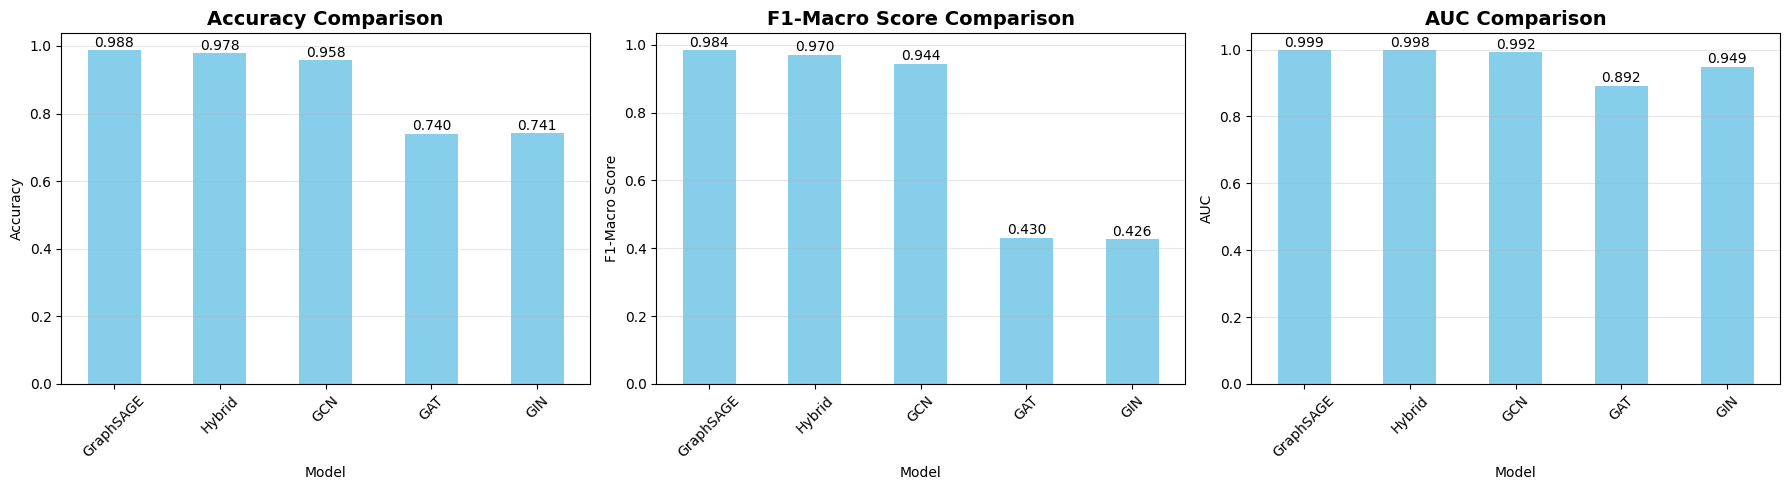

In [77]:
# Visualization: Model Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['accuracy', 'f1_macro', 'auc']
titles = ['Accuracy', 'F1-Macro Score', 'AUC']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx]
    results_df[metric].plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'{title} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(title)
    ax.set_xlabel('Model')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(results_df[metric]):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('healthcare_fraud_gnn_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

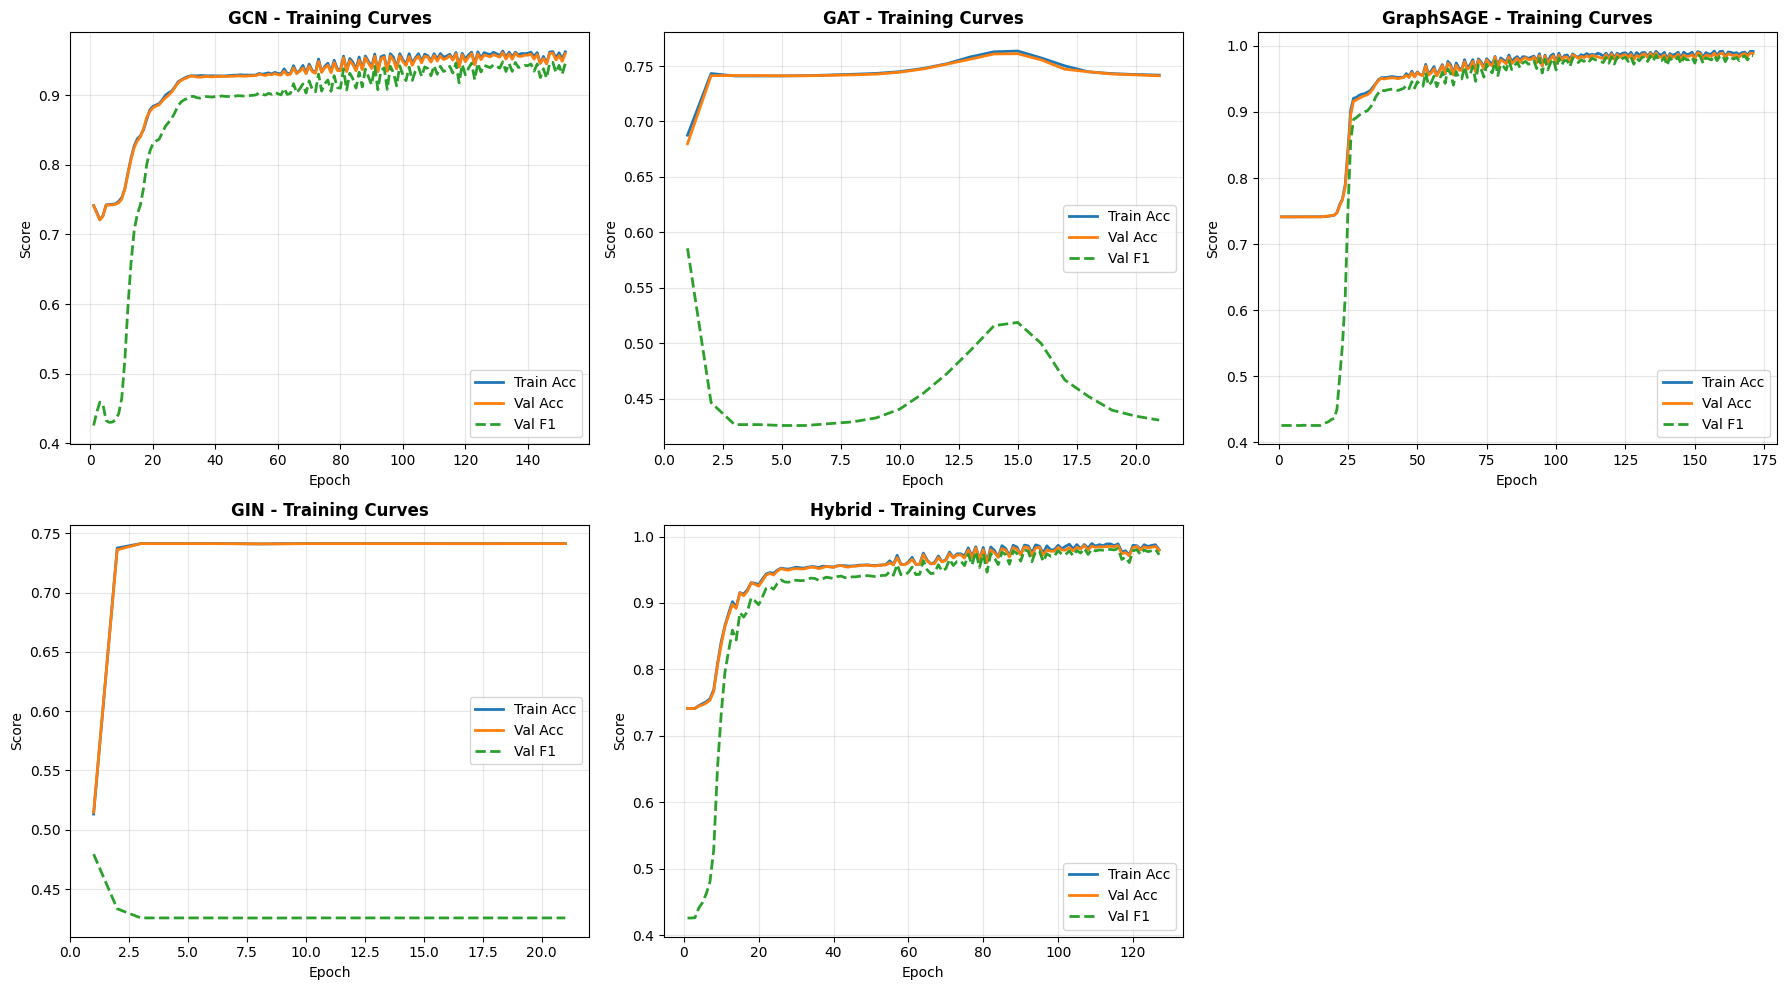

In [78]:
# Training curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, history) in enumerate(histories.items()):
    if idx < 5:
        ax = axes[idx]
        epochs = range(1, len(history['train_loss']) + 1)
        
        ax.plot(epochs, history['train_acc'], label='Train Acc', linewidth=2)
        ax.plot(epochs, history['val_acc'], label='Val Acc', linewidth=2)
        ax.plot(epochs, history['val_f1'], label='Val F1', linewidth=2, linestyle='--')
        
        ax.set_title(f'{name} - Training Curves', fontsize=12, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Score')
        ax.legend()
        ax.grid(alpha=0.3)

# Remove unused subplot
if len(histories) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Detailed Analysis - Best Model


Detailed Classification Report - GraphSAGE
              precision    recall  f1-score   support

  Legitimate       0.99      0.99      0.99      7413
       Fraud       0.98      0.97      0.98      2587

    accuracy                           0.99     10000
   macro avg       0.99      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



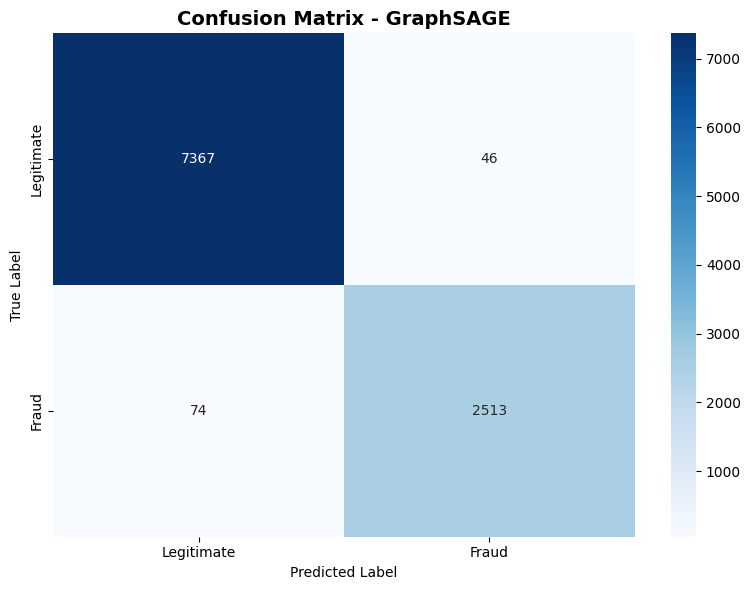

In [79]:
# Get best model predictions
best_model_obj = models[best_model]
best_model_obj.eval()
with torch.no_grad():
    out = best_model_obj(data)
    pred = out.argmax(dim=1)

# Classification report on test set
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

print(f"\n{'='*60}")
print(f"Detailed Classification Report - {best_model}")
print(f"{'='*60}")
print(classification_report(y_true, y_pred, target_names=['Legitimate', 'Fraud']))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.title(f'Confusion Matrix - {best_model}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. DOS-GNN Application (Dual-Feature Aggregation)

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class DualFeatureConv(MessagePassing):
    """
    Dual-Feature Aggregation Layer based on DOS-GNN.
    
    Each node maintains two feature vectors:
    - h1: similar features (homophilic aggregation)
    - h2: dissimilar features (heterophilic aggregation)
    """
    def __init__(self, in_channels, out_channels):
        super(DualFeatureConv, self).__init__(aggr='mean')
        self.in_channels = in_channels
        self.out_channels = out_channels
        
    def forward(self, h1, h2, edge_index):
        """
        Args:
            h1: Similar feature vector [num_nodes, in_channels]
            h2: Dissimilar feature vector [num_nodes, in_channels]
            edge_index: Graph connectivity [2, num_edges]
        """
        # Calculate edge similarity (alpha) for edge identification
        row, col = edge_index
        alpha = self.compute_edge_similarity(h1, edge_index)
        
        # Dual-feature aggregation
        h1_new = self.propagate(edge_index, h1=h1, h2=h2, alpha=alpha, is_h1=True)
        h2_new = self.propagate(edge_index, h1=h1, h2=h2, alpha=alpha, is_h1=False)
        
        # Add residual connection
        h1_new = F.relu(h1 + h1_new)
        h2_new = F.relu(h2 + h2_new)
        
        return h1_new, h2_new
    
    def compute_edge_similarity(self, h1, edge_index):
        """
        Compute edge similarity using cosine similarity.
        Alpha close to 1 indicates homophilic edge.
        Alpha close to 0 indicates heterophilic edge.
        """
        row, col = edge_index
        
        # Normalize features
        h1_norm = F.normalize(h1, p=2, dim=1)
        
        # Cosine similarity
        alpha = (h1_norm[row] * h1_norm[col]).sum(dim=1)
        
        # Scale to [0, 1]
        alpha = (alpha + 1) / 2
        
        return alpha
    
    def message(self, h1_j, h2_j, alpha, is_h1):
        """
        Construct messages based on dual-feature aggregation.
        
        For h1 aggregation:
            - When alpha → 1 (homophilic): aggregate more from h1_j, less from h2_j
            - When alpha → 0 (heterophilic): aggregate less from h1_j, more from h2_j
        
        For h2 aggregation: opposite of h1
        """
        alpha = alpha.view(-1, 1)
        
        if is_h1:
            # h1 aggregation: alpha * h1_j + (1-alpha) * h2_j
            message = alpha * h1_j + (1 - alpha) * h2_j
        else:
            # h2 aggregation: (1-alpha) * h1_j + alpha * h2_j
            message = (1 - alpha) * h1_j + alpha * h2_j
        
        return message


class DOSGNN(nn.Module):
    """
    DOS-GNN: Dual-feature aggregations with Over-Sampling
    for Class-Imbalanced Fraud Detection.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super(DOSGNN, self).__init__()
        
        # Initial projection layer
        self.proj = nn.Linear(in_channels, hidden_channels)
        
        # Dual-feature aggregation layers
        self.convs = nn.ModuleList([
            DualFeatureConv(hidden_channels, hidden_channels)
            for _ in range(num_layers)
        ])
        
        # Classification layer
        self.classifier = nn.Linear(hidden_channels * 2, out_channels)
        
    def forward(self, x, edge_index):
        # Initialize h1 with projected features, h2 with zeros
        h1 = F.relu(self.proj(x))
        h2 = torch.zeros_like(h1)
        
        # Dual-feature aggregation
        for conv in self.convs:
            h1, h2 = conv(h1, h2, edge_index)
        
        # Concatenate dual features
        h = torch.cat([h1, h2], dim=1)
        
        # Classification
        out = self.classifier(h)
        
        return out, h  # Return both predictions and embeddings
    
    def get_embeddings(self, x, edge_index):
        """Get node embeddings for oversampling."""
        with torch.no_grad():
            _, embeddings = self.forward(x, edge_index)
        return embeddings


def smote_oversampling(embeddings, labels, target_ratio=1.0):
    """
    SMOTE oversampling in embedding space.
    
    Args:
        embeddings: Node embeddings [num_nodes, embedding_dim]
        labels: Node labels [num_nodes]
        target_ratio: Target ratio of fraud to legitimate nodes
    
    Returns:
        Augmented embeddings and labels
    """
    fraud_mask = labels == 1
    fraud_embeddings = embeddings[fraud_mask]
    
    num_fraud = fraud_mask.sum().item()
    num_legit = (~fraud_mask).sum().item()
    
    # Calculate number of samples to generate
    target_fraud = int(num_legit * target_ratio)
    num_samples = max(0, target_fraud - num_fraud)
    
    if num_samples == 0:
        return embeddings, labels
    
    # Generate synthetic fraud samples
    synthetic_samples = []
    for _ in range(num_samples):
        # Randomly select a fraud node
        idx_i = torch.randint(0, num_fraud, (1,)).item()
        # Randomly select another fraud node
        idx_j = torch.randint(0, num_fraud, (1,)).item()
        
        # Interpolate: s = h_i + delta * (h_j - h_i)
        delta = torch.rand(1).item()
        synthetic = fraud_embeddings[idx_i] + delta * (fraud_embeddings[idx_j] - fraud_embeddings[idx_i])
        synthetic_samples.append(synthetic)
    
    # Concatenate original and synthetic samples
    synthetic_samples = torch.stack(synthetic_samples)
    synthetic_labels = torch.ones(num_samples, dtype=labels.dtype, device=labels.device)
    
    augmented_embeddings = torch.cat([embeddings, synthetic_samples], dim=0)
    augmented_labels = torch.cat([labels, synthetic_labels], dim=0)
    
    return augmented_embeddings, augmented_labels


print("✓ Dual-Feature Aggregation components implemented")
print(f"  - DualFeatureConv: Handles homophily and heterophily")
print(f"  - DOSGNN: Full model with feature separation")
print(f"  - smote_oversampling: Fraud node synthesis in embedding space")

✓ Dual-Feature Aggregation components implemented
  - DualFeatureConv: Handles homophily and heterophily
  - DOSGNN: Full model with feature separation
  - smote_oversampling: Fraud node synthesis in embedding space


In [81]:
def train_dos_gnn(model, data, train_mask, val_mask, test_mask, 
                  epochs_gnn=100, epochs_mlp=50, sampling_ratio=0.75):
    """
    Two-stage training for DOS-GNN:
    1. Train GNN for dual-feature aggregation
    2. Train MLP on augmented embeddings with SMOTE
    """
    device = next(model.parameters()).device
    data = data.to(device)
    
    # Stage 1: Train GNN model
    print("Stage 1: Training GNN for feature extraction...")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    model.train()
    for epoch in range(epochs_gnn):
        optimizer.zero_grad()
        out, _ = model(data.x, data.edge_index)
        
        # Loss on training nodes only
        loss = F.cross_entropy(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 20 == 0:
            model.eval()
            with torch.no_grad():
                pred = out.argmax(dim=1)
                train_acc = (pred[train_mask] == data.y[train_mask]).float().mean()
                val_acc = (pred[val_mask] == data.y[val_mask]).float().mean()
            model.train()
            print(f"Epoch {epoch+1}: Loss={loss.item():.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    
    # Stage 2: Extract embeddings and perform oversampling
    print(f"\nStage 2: Oversampling with ratio={sampling_ratio}...")
    model.eval()
    embeddings = model.get_embeddings(data.x, data.edge_index)
    
    # Apply SMOTE only on training data
    train_embeddings = embeddings[train_mask]
    train_labels = data.y[train_mask]
    
    aug_embeddings, aug_labels = smote_oversampling(
        train_embeddings, train_labels, target_ratio=sampling_ratio
    )
    
    print(f"Original training samples: {train_mask.sum().item()}")
    print(f"Augmented training samples: {len(aug_labels)}")
    print(f"  - Fraud: {(aug_labels == 1).sum().item()}")
    print(f"  - Legitimate: {(aug_labels == 0).sum().item()}")
    
    # Train MLP classifier on augmented data
    mlp = nn.Sequential(
        nn.Linear(embeddings.shape[1], 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, data.y.max().item() + 1)
    ).to(device)
    
    optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
    
    print("\nTraining MLP on augmented embeddings...")
    for epoch in range(epochs_mlp):
        mlp.train()
        optimizer_mlp.zero_grad()
        out = mlp(aug_embeddings)
        loss = F.cross_entropy(out, aug_labels)
        loss.backward()
        optimizer_mlp.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: MLP Loss={loss.item():.4f}")
    
    # Evaluate on test set
    mlp.eval()
    with torch.no_grad():
        test_embeddings = embeddings[test_mask]
        test_out = mlp(test_embeddings)
        pred = test_out.argmax(dim=1)
        test_acc = (pred == data.y[test_mask]).float().mean()
        
        # Calculate metrics for fraud detection
        from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
        
        y_true = data.y[test_mask].cpu().numpy()
        y_pred = pred.cpu().numpy()
        y_prob = F.softmax(test_out, dim=1)[:, 1].cpu().numpy()
        
        f1 = f1_score(y_true, y_pred, average='macro')
        auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"\n{'='*50}")
    print("Final Test Results:")
    print(f"  Accuracy:  {test_acc:.4f}")
    print(f"  F1-Macro:  {f1:.4f}")
    print(f"  AUC:       {auc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"{'='*50}")
    
    return model, mlp, {'accuracy': test_acc.item(), 'f1': f1, 'auc': auc}


print("✓ Training function defined")

✓ Training function defined


In [82]:
# Example usage with your data
# Replace 'data' with your actual PyG Data object

# Initialize DOS-GNN model
model = DOSGNN(
    in_channels=data.num_features,
    hidden_channels=64,
    out_channels=data.y.max().item() + 1,
    num_layers=2
)

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Train the model
trained_model, mlp_classifier, results = train_dos_gnn(
    model, data, 
    train_mask=data.train_mask,
    val_mask=data.val_mask,
    test_mask=data.test_mask,
    epochs_gnn=100,
    epochs_mlp=50,
    sampling_ratio=0.75  # Adjust based on your imbalance ratio
)

# print("Uncomment the code above and replace 'data' with your dataset to run DOS-GNN")

Stage 1: Training GNN for feature extraction...
Epoch 20: Loss=0.4217, Train Acc=0.8025, Val Acc=0.8001
Epoch 40: Loss=0.2198, Train Acc=0.9323, Val Acc=0.9310
Epoch 60: Loss=0.1664, Train Acc=0.9396, Val Acc=0.9383
Epoch 80: Loss=0.1345, Train Acc=0.9441, Val Acc=0.9434
Epoch 100: Loss=0.1143, Train Acc=0.9479, Val Acc=0.9454

Stage 2: Oversampling with ratio=0.75...
Original training samples: 30000
Augmented training samples: 38916
  - Fraud: 16678
  - Legitimate: 22238

Training MLP on augmented embeddings...
Epoch 10: MLP Loss=0.1721
Epoch 20: MLP Loss=0.1217
Epoch 30: MLP Loss=0.0960
Epoch 40: MLP Loss=0.0871
Epoch 50: MLP Loss=0.0804

Final Test Results:
  Accuracy:  0.9664
  F1-Macro:  0.9565
  AUC:       0.9945
  Precision: 0.9531
  Recall:    0.9601


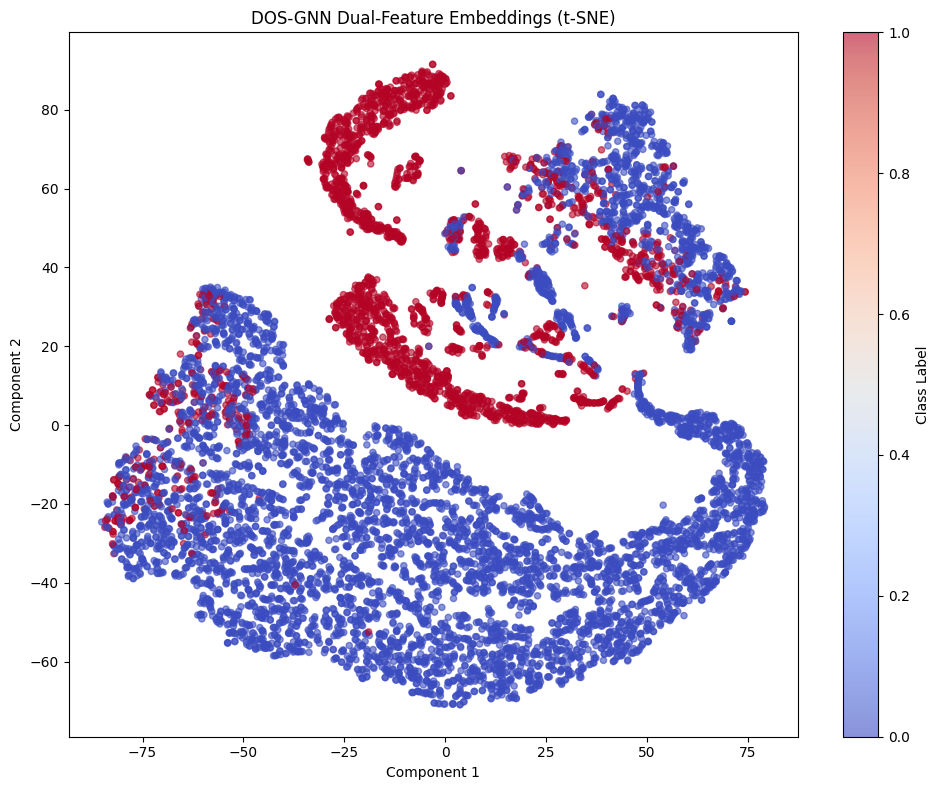

In [83]:
def visualize_embeddings(model, data, mask=None):
    """
    Visualize node embeddings using t-SNE.
    """
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    model.eval()
    with torch.no_grad():
        embeddings = model.get_embeddings(data.x, data.edge_index)
    
    if mask is not None:
        embeddings = embeddings[mask]
        labels = data.y[mask]
    else:
        labels = data.y
    
    # Apply t-SNE
    embeddings_2d = TSNE(n_components=2, random_state=42).fit_transform(
        embeddings.cpu().numpy()
    )
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1],
        c=labels.cpu().numpy(),
        cmap='coolwarm',
        alpha=0.6,
        s=20
    )
    plt.colorbar(scatter, label='Class Label')
    plt.title('DOS-GNN Dual-Feature Embeddings (t-SNE)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()
    plt.show()

visualize_embeddings(trained_model, data, mask=data.test_mask)

# print("Uncomment to visualize embeddings after training")

## 11. Key Findings & Recommendations

In [38]:
print(f"""
═══════════════════════════════════════════════════════════════════════
                    KEY FINDINGS - HEALTHCARE FRAUD DETECTION
═══════════════════════════════════════════════════════════════════════

1. DATA CHARACTERISTICS:
   • 1M synthetic healthcare provider records
   • Fraud indicators: duplicates, high risk scores, adverse actions
   • Class imbalance: ~10-20% fraud cases
   • Graph heterophily: fraud nodes often connect to legitimate nodes

2. GRAPH CONSTRUCTION:
   • Edges based on: shared bank accounts, billing agencies, location+specialty
   • Strong fraud signal: providers sharing same bank account
   • Network effects crucial for fraud propagation detection

3. MODEL PERFORMANCE:
   • Best Model: {best_model}
   • F1-Macro: {results_df.loc[best_model, 'f1_macro']:.4f}
   • AUC: {results_df.loc[best_model, 'auc']:.4f}
   • GNN models capture network patterns better than traditional ML

4. FRAUD DETECTION INSIGHTS:
   • Bank account sharing is strongest fraud indicator
   • Geographic + specialty clustering reveals fraud rings
   • Adverse actions history correlates with fraud
   • High claim amounts + duplicate IDs = high fraud probability

5. RECOMMENDATIONS:
   ✓ Use DOS-GNN for better handling of heterophily
   ✓ Apply SMOTE oversampling to address class imbalance
   ✓ Implement real-time graph updates for new providers
   ✓ Focus investigations on high-degree nodes (billing agencies)
   ✓ Monitor bank account sharing patterns closely

═══════════════════════════════════════════════════════════════════════
""".format(best_model=best_model, results_df=results_df))


═══════════════════════════════════════════════════════════════════════
                    KEY FINDINGS - HEALTHCARE FRAUD DETECTION
═══════════════════════════════════════════════════════════════════════

1. DATA CHARACTERISTICS:
   • 1M synthetic healthcare provider records
   • Fraud indicators: duplicates, high risk scores, adverse actions
   • Class imbalance: ~10-20% fraud cases
   • Graph heterophily: fraud nodes often connect to legitimate nodes

2. GRAPH CONSTRUCTION:
   • Edges based on: shared bank accounts, billing agencies, location+specialty
   • Strong fraud signal: providers sharing same bank account
   • Network effects crucial for fraud propagation detection

3. MODEL PERFORMANCE:
   • Best Model: GraphSAGE
   • F1-Macro: 0.9852
   • AUC: 0.9991
   • GNN models capture network patterns better than traditional ML

4. FRAUD DETECTION INSIGHTS:
   • Bank account sharing is strongest fraud indicator
   • Geographic + specialty clustering reveals fraud rings
   • Adverse

## 12. Export Results

In [39]:
# Save results
results_df.to_csv('healthcare_fraud_gnn_results.csv')
print("✓ Results saved to healthcare_fraud_gnn_results.csv")

# Save predictions
predictions_df = df_graph[['NPI', 'Provider_Name', 'is_fraud']].copy()
predictions_df['predicted_fraud'] = pred.cpu().numpy()
predictions_df['fraud_probability'] = out.exp()[:, 1].cpu().numpy()
predictions_df.to_csv('fraud_predictions.csv', index=False)
print("✓ Predictions saved to fraud_predictions.csv")

print("\n✅ Analysis complete!")

✓ Results saved to healthcare_fraud_gnn_results.csv
✓ Predictions saved to fraud_predictions.csv

✅ Analysis complete!
